In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch

# Define your dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokenized = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        input_ids = tokenized['input_ids'].squeeze(0)  # Squeeze to remove batch dimension
        attention_mask = tokenized['attention_mask'].squeeze(0)
        label = torch.tensor(self.labels[idx])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# Example data
texts = ["This is the best movie ever!", "I did not like this movie at all."]
labels = [1, 0]  # 1 for positive, 0 for negative

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create the dataset
dataset = TextDataset(texts, labels, tokenizer)

# Load the pre-trained model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='../results/sandbox/',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('../results/sandbox/fine_tuned_model')


/Users/erinconrad/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification f

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ../results/fine_tuned_model/config.json
Model weights saved in ../results/fine_tuned_model/pytorch_model.bin


In [7]:
tokenizer.save_pretrained('../results/sandbox/fine_tuned_model')


tokenizer config file saved in ../results/sandbox/fine_tuned_model/tokenizer_config.json
Special tokens file saved in ../results/sandbox/fine_tuned_model/special_tokens_map.json


('../results/sandbox/fine_tuned_model/tokenizer_config.json',
 '../results/sandbox/fine_tuned_model/special_tokens_map.json',
 '../results/sandbox/fine_tuned_model/vocab.txt',
 '../results/sandbox/fine_tuned_model/added_tokens.json')

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('../results/sandbox/fine_tuned_model')
model = BertForSequenceClassification.from_pretrained('../results/sandbox/fine_tuned_model')


loading file vocab.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file ../results/sandbox/fine_tuned_model/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file ../results/sandbox/fine_tu

In [9]:
test_texts = [
    "This product has exceeded my expectations.",
    "I'm deeply disappointed with the service.",
    "An absolutely fantastic experience!",
    "The quality is terrible, not what I expected at all.",
    "Delivery was quick and the item was as described. Very satisfied.",
    "Will never order from here again. Completely dissatisfied.",
    "The movie was a great watch, thoroughly enjoyed it.",
    "One of the worst movies I've seen. A complete waste of time."
]

# Tokenize the test data
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")


In [65]:
import torch

# Predict
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)

# Convert predictions to a list for easy viewing
predictions = predictions.tolist()

# Display the predictions
for text, prediction in zip(test_texts, predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Text: {text}\nSentiment: {sentiment}\n")


Text: This product has exceeded my expectations.
Sentiment: Negative

Text: I'm deeply disappointed with the service.
Sentiment: Positive

Text: An absolutely fantastic experience!
Sentiment: Positive

Text: The quality is terrible, not what I expected at all.
Sentiment: Negative

Text: Delivery was quick and the item was as described. Very satisfied.
Sentiment: Negative

Text: Will never order from here again. Completely dissatisfied.
Sentiment: Negative

Text: The movie was a great watch, thoroughly enjoyed it.
Sentiment: Negative

Text: One of the worst movies I've seen. A complete waste of time.
Sentiment: Positive



In [11]:
import torch
from torch.nn.functional import softmax

# Assuming outputs.logits from the model's forward pass
with torch.no_grad():
    outputs = model(**test_encodings)
    probabilities = softmax(outputs.logits, dim=-1)
    positive_class_probabilities = probabilities[:, 1]  # Assuming class '1' is the positive class


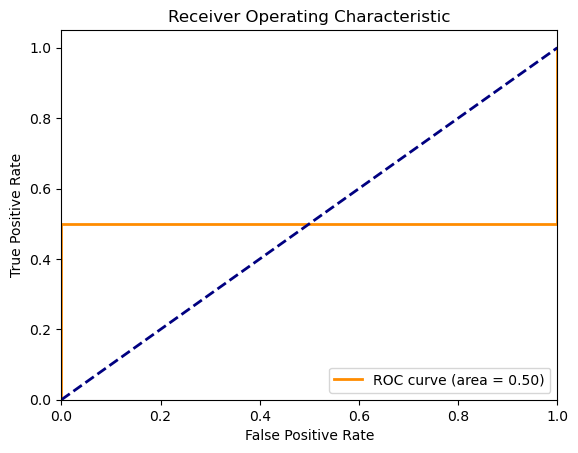

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True binary labels of the test set
y_true = [1, 0, 1, 0, 1, 0, 1, 0]  # Example labels

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, positive_class_probabilities.numpy())

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
